In [1]:
# Core Data Science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_auc_score,
    cohen_kappa_score, matthews_corrcoef
)

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# XGBoost
import xgboost as xgb

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# Load and inspect the preprocessed dataset

# Load data
df = pd.read_csv('Final_Dataset_with_dataset.csv')

print(f"  Shape: {df.shape}")
print(f"  Rows (samples): {df.shape[0]}")
print(f"  Columns (features): {df.shape[1]}")

# Check last columns (should be clinical + labels)
print("LAST 5 COLUMNS:")
print(df.columns[-5:].tolist())

# Dataset composition
print("DATASET COMPOSITION:")
print("\nBy source:")
print(df['Dataset'].value_counts())

print("\nBy diagnosis:")
print(df['Diagnosis'].value_counts())

print("\nCross-tabulation (Dataset × Diagnosis):")
print(pd.crosstab(df['Dataset'], df['Diagnosis']))

# Check for missing values
missing = df.isnull().sum().sum()
print(f"MISSING VALUES: {missing}")
if missing > 0:
    print("Warning: Missing values detected")
else:
    print("No missing values")

  Shape: (1042, 1004)
  Rows (samples): 1042
  Columns (features): 1004
LAST 5 COLUMNS:
['IL4I1', 'Age_Zscore', 'Sex_Male', 'Diagnosis', 'Dataset']
DATASET COMPOSITION:

By source:
Dataset
ADNI         700
GSE110226    329
GSE63060      13
Name: count, dtype: int64

By diagnosis:
Diagnosis
MCI        519
Control    371
AD         152
Name: count, dtype: int64

Cross-tabulation (Dataset × Diagnosis):
Diagnosis   AD  Control  MCI
Dataset                     
ADNI         0      261  439
GSE110226  145      104   80
GSE63060     7        6    0
MISSING VALUES: 0
No missing values


In [10]:
# Prepare data for modeling

# Separate features and target
feature_cols = [col for col in df.columns if col not in ['Diagnosis', 'Dataset']]
X = df[feature_cols].values
y = df['Diagnosis'].values

print(f"\nFeature matrix: {X.shape}")
print(f"  Features: {X.shape[1]} (1000 genes + Age_Zscore + Sex_Male)")

print(f"\nTarget vector: {y.shape}")
print(f"  Classes: {np.unique(y)}")

# Encode labels (AD=0, Control=1, MCI=2)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("LABEL ENCODING:")
for i, class_name in enumerate(le.classes_):
    count = np.sum(y_encoded == i)
    print(f"  {class_name:10s} : {i}  ({count} samples)")

# Stratified train/test split BEFORE SMOTE
print("STRATIFIED TRAIN/TEST SPLIT (80/20)")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.20,
    stratify=y_encoded,  # Ensures balanced classes
    random_state=RANDOM_STATE
)

print(f"\nTraining set: {X_train.shape[0]} samples")
train_dist = pd.Series(y_train).value_counts().sort_index()
for i, count in enumerate(train_dist):
    class_name = le.inverse_transform([i])[0]
    pct = 100 * count / len(y_train)
    print(f"    {class_name:10s}: {count:3d} ({pct:5.1f}%)")

print(f"\nTest set: {X_test.shape[0]} samples")
test_dist = pd.Series(y_test).value_counts().sort_index()
for i, count in enumerate(test_dist):
    class_name = le.inverse_transform([i])[0]
    pct = 100 * count / len(y_test)
    print(f"    {class_name:10s}: {count:3d} ({pct:5.1f}%)")

# Calculate imbalance ratio
print("CLASS IMBALANCE ANALYSIS:")
imbalance_ratio = train_dist.max() / train_dist.min()
print(f"  Majority class: {train_dist.max()} samples")
print(f"  Minority class: {train_dist.min()} samples")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")


Feature matrix: (1042, 1002)
  Features: 1002 (1000 genes + Age_Zscore + Sex_Male)

Target vector: (1042,)
  Classes: ['AD' 'Control' 'MCI']
LABEL ENCODING:
  AD         : 0  (152 samples)
  Control    : 1  (371 samples)
  MCI        : 2  (519 samples)
STRATIFIED TRAIN/TEST SPLIT (80/20)

Training set: 833 samples
    AD        : 121 ( 14.5%)
    Control   : 297 ( 35.7%)
    MCI       : 415 ( 49.8%)

Test set: 209 samples
    AD        :  31 ( 14.8%)
    Control   :  74 ( 35.4%)
    MCI       : 104 ( 49.8%)
CLASS IMBALANCE ANALYSIS:
  Majority class: 415 samples
  Minority class: 121 samples
  Imbalance ratio: 3.43:1


In [11]:
# Apply SMOTE to training data

# Store original training set info
print(f"\nBEFORE SMOTE:")
print(f"  Training set: {X_train.shape[0]} samples")
original_train_dist = pd.Series(y_train).value_counts().sort_index()
for i, count in enumerate(original_train_dist):
    class_name = le.inverse_transform([i])[0]
    print(f"    {class_name:10s}: {count:3d} samples")

# Apply SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\nAFTER SMOTE:")
print(f"  Training set: {X_train_resampled.shape[0]} samples")
resampled_train_dist = pd.Series(y_train_resampled).value_counts().sort_index()
for i, count in enumerate(resampled_train_dist):
    class_name = le.inverse_transform([i])[0]
    synthetic = count - original_train_dist.iloc[i]
    print(f"    {class_name:10s}: {count:3d} samples (+{synthetic} synthetic)")

print(f"\nTest set: {X_test.shape[0]} samples (UNCHANGED)")
print("  No synthetic data in test set (proper evaluation!)")

print("SUMMARY:")
print(f"  Original training samples: {X_train.shape[0]}")
print(f"  After SMOTE: {X_train_resampled.shape[0]}")
print(f"  Synthetic samples added: {X_train_resampled.shape[0] - X_train.shape[0]}")
print(f"  Test samples: {X_test.shape[0]} (unchanged)")


BEFORE SMOTE:
  Training set: 833 samples
    AD        : 121 samples
    Control   : 297 samples
    MCI       : 415 samples

AFTER SMOTE:
  Training set: 1245 samples
    AD        : 415 samples (+294 synthetic)
    Control   : 415 samples (+118 synthetic)
    MCI       : 415 samples (+0 synthetic)

Test set: 209 samples (UNCHANGED)
  No synthetic data in test set (proper evaluation!)
SUMMARY:
  Original training samples: 833
  After SMOTE: 1245
  Synthetic samples added: 412
  Test samples: 209 (unchanged)


In [12]:
# Define evaluation function

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, class_names):
    """
    Train and evaluate a model with comprehensive metrics
    """
    import time

    # Train model
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predictions
    y_pred = model.predict(X_test)

    # Probabilities (for ROC-AUC)
    try:
        y_proba = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
    except:
        roc_auc = None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, average=None
    )

    # Additional metrics
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Store results
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_per_class': f1,
        'support_per_class': support,
        'cohen_kappa': kappa,
        'mcc': mcc,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'train_time': train_time,
    }

    return results


def print_results(results, class_names):
    """
    Print formatted results
    """
    print(f"Model: {results['model_name']}")
    print(f"\nOVERALL METRICS:")
    print(f"  Accuracy:      {results['accuracy']:.4f}")
    print(f"  Macro F1:      {results['macro_f1']:.4f}")
    print(f"  Weighted F1:   {results['weighted_f1']:.4f}")
    print(f"  Cohen's Kappa: {results['cohen_kappa']:.4f}")
    print(f"  MCC:           {results['mcc']:.4f}")
    if results['roc_auc']:
        print(f"  ROC-AUC:       {results['roc_auc']:.4f}")
    print(f"  Training time: {results['train_time']:.2f}s")

    print(f"\nPER-CLASS METRICS:")
    print(f"  {'Class':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
    print(f"  {'-'*60}")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name:<12} {results['precision_per_class'][i]:<12.4f} "
              f"{results['recall_per_class'][i]:<12.4f} "
              f"{results['f1_per_class'][i]:<12.4f} "
              f"{int(results['support_per_class'][i]):<12}")

    print(f"\nCONFUSION MATRIX:")
    cm = results['confusion_matrix']
    print(f"  {'Actual →':<12}", end='')
    for class_name in class_names:
        print(f"{class_name:<12}", end='')
    print("\n  Predicted ↓")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name:<12}", end='')
        for j in range(len(class_names)):
            print(f"{cm[i,j]:<12}", end='')
        print()


# Test the functions
print("EVALUATION FUNCTIONS DEFINED")
print("evaluate_model() - trains and evaluates with 10+ metrics")
print("print_results() - displays formatted results")
print("\nReady to train models!")

EVALUATION FUNCTIONS DEFINED
evaluate_model() - trains and evaluates with 10+ metrics
print_results() - displays formatted results

Ready to train models!


In [13]:
# Baseline Model #1 - Logistic Regression
print("LOGISTIC REGRESSION")

# Get class names for reporting
class_names = le.classes_

# Initialize model
logreg = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("\nTraining Logistic Regression (L2):")


# Train and evaluate
lr_results = evaluate_model(
    logreg,
    X_train_resampled,
    y_train_resampled,
    X_test,
    y_test,
    'Logistic Regression',
    class_names
)

# Print results
print_results(lr_results, class_names)

# Store results for comparison later
baseline_results = {'Logistic Regression': lr_results}

print("\nLogistic Regression complete!")

LOGISTIC REGRESSION

Training Logistic Regression (L2):
Model: Logistic Regression

OVERALL METRICS:
  Accuracy:      0.5359
  Macro F1:      0.5655
  Weighted F1:   0.5339
  Cohen's Kappa: 0.2520
  MCC:           0.2529
  ROC-AUC:       0.7353
  Training time: 3.59s

PER-CLASS METRICS:
  Class        Precision    Recall       F1-Score     Support     
  ------------------------------------------------------------
  AD           0.6410       0.8065       0.7143       31          
  Control      0.4156       0.4324       0.4238       74          
  MCI          0.5914       0.5288       0.5584       104         

CONFUSION MATRIX:
  Actual →    AD          Control     MCI         
  Predicted ↓
  AD          25          5           1           
  Control     5           32          37          
  MCI         9           40          55          

Logistic Regression complete!


In [17]:
# Baseline Model #2 - Support Vector Machine

print("SUPPORT VECTOR MACHINE (SVM)")

# Initialize model
svm_model = SVC(
    kernel='rbf',
    random_state=RANDOM_STATE,
    probability=True  # Needed for ROC-AUC
)

print("\nTraining SVM (RBF kernel): ")

# Train and evaluate
svm_results = evaluate_model(
    svm_model,
    X_train_resampled,
    y_train_resampled,
    X_test,
    y_test,
    'SVM',
    class_names
)

# Print results
print_results(svm_results, class_names)

# Store results
baseline_results['SVM'] = svm_results

print("\nSVM complete!")

SUPPORT VECTOR MACHINE (SVM)

Training SVM (RBF kernel): 
Model: SVM

OVERALL METRICS:
  Accuracy:      0.5502
  Macro F1:      0.5394
  Weighted F1:   0.5249
  Cohen's Kappa: 0.2736
  MCC:           0.2824
  ROC-AUC:       0.7274
  Training time: 2.46s

PER-CLASS METRICS:
  Class        Precision    Recall       F1-Score     Support     
  ------------------------------------------------------------
  AD           0.5283       0.9032       0.6667       31          
  Control      0.4634       0.2568       0.3304       74          
  MCI          0.5913       0.6538       0.6210       104         

CONFUSION MATRIX:
  Actual →    AD          Control     MCI         
  Predicted ↓
  AD          28          3           0           
  Control     8           19          47          
  MCI         17          19          68          

SVM complete!


In [18]:
# Baseline Model #3 - Random Forest

print("RANDOM FOREST")

# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("\n Training Random Forest:")


# Train and evaluate
rf_results = evaluate_model(
    rf_model,
    X_train_resampled,
    y_train_resampled,
    X_test,
    y_test,
    'Random Forest',
    class_names
)

# Print results
print_results(rf_results, class_names)

# Store results
baseline_results['Random Forest'] = rf_results

print("\nRandom Forest complete!")

RANDOM FOREST

 Training Random Forest:
Model: Random Forest

OVERALL METRICS:
  Accuracy:      0.5837
  Macro F1:      0.5529
  Weighted F1:   0.5410
  Cohen's Kappa: 0.3056
  MCC:           0.3281
  ROC-AUC:       0.7504
  Training time: 0.57s

PER-CLASS METRICS:
  Class        Precision    Recall       F1-Score     Support     
  ------------------------------------------------------------
  AD           0.5745       0.8710       0.6923       31          
  Control      0.5556       0.2027       0.2970       74          
  MCI          0.5926       0.7692       0.6695       104         

CONFUSION MATRIX:
  Actual →    AD          Control     MCI         
  Predicted ↓
  AD          27          3           1           
  Control     5           15          54          
  MCI         15          9           80          

Random Forest complete!


In [19]:
# Baseline Model #4 - XGBoost

print("XGBOOST")

# Initialize model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    eval_metric='mlogloss',
    use_label_encoder=False
)

print("\n Training XGBoost: ")

# Train and evaluate
xgb_results = evaluate_model(
    xgb_model,
    X_train_resampled,
    y_train_resampled,
    X_test,
    y_test,
    'XGBoost',
    class_names
)

# Print results
print_results(xgb_results, class_names)

# Store results
baseline_results['XGBoost'] = xgb_results

print("\nXGBoost complete!")

XGBOOST

 Training XGBoost: 
Model: XGBoost

OVERALL METRICS:
  Accuracy:      0.5789
  Macro F1:      0.5817
  Weighted F1:   0.5734
  Cohen's Kappa: 0.3099
  MCC:           0.3112
  ROC-AUC:       0.7678
  Training time: 9.26s

PER-CLASS METRICS:
  Class        Precision    Recall       F1-Score     Support     
  ------------------------------------------------------------
  AD           0.5897       0.7419       0.6571       31          
  Control      0.5000       0.4189       0.4559       74          
  MCI          0.6204       0.6442       0.6321       104         

CONFUSION MATRIX:
  Actual →    AD          Control     MCI         
  Predicted ↓
  AD          23          7           1           
  Control     3           31          40          
  MCI         13          24          67          

XGBoost complete!


BASELINE MODELS COMPARISON (4 models trained)

 RESULTS TABLE:
              Model  Accuracy  Macro F1  Weighted F1  Cohen Kappa      MCC  ROC-AUC  Train Time (s)
            XGBoost  0.578947  0.581700     0.573409     0.309920 0.311231 0.767755        9.261169
Logistic Regression  0.535885  0.565501     0.533867     0.251974 0.252937 0.735305        3.593590
      Random Forest  0.583732  0.552931     0.540982     0.305621 0.328062 0.750403        0.570441
                SVM  0.550239  0.539369     0.524896     0.273554 0.282410 0.727436        2.455672
CURRENT BEST MODEL: XGBoost
   Macro F1: 0.5817


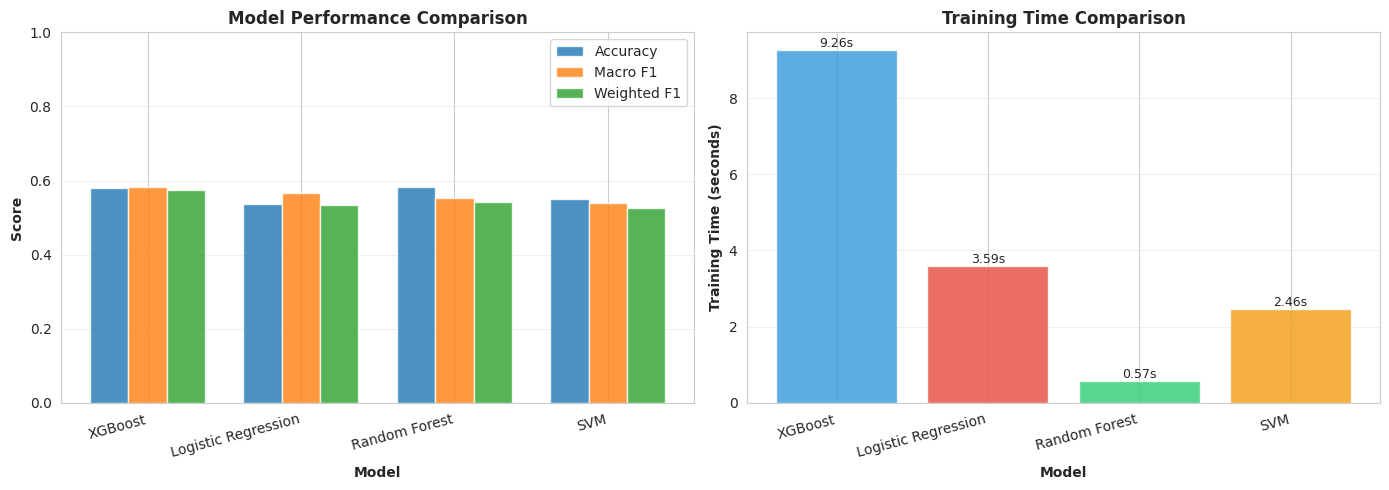


Comparison complete!


In [20]:
# Compare baseline models (first 4)

print("BASELINE MODELS COMPARISON (4 models trained)")

# Create comparison dataframe
comparison_data = []
for model_name, results in baseline_results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': results['accuracy'],
        'Macro F1': results['macro_f1'],
        'Weighted F1': results['weighted_f1'],
        'Cohen Kappa': results['cohen_kappa'],
        'MCC': results['mcc'],
        'ROC-AUC': results['roc_auc'] if results['roc_auc'] else 0,
        'Train Time (s)': results['train_time']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Macro F1', ascending=False)

print("\n RESULTS TABLE:")
print(comparison_df.to_string(index=False))

# Find best model so far
best_model = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['Macro F1']

print(f"CURRENT BEST MODEL: {best_model}")
print(f"   Macro F1: {best_f1:.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy and F1 scores
ax = axes[0]
x = np.arange(len(comparison_df))
width = 0.25
ax.bar(x - width, comparison_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x, comparison_df['Macro F1'], width, label='Macro F1', alpha=0.8)
ax.bar(x + width, comparison_df['Weighted F1'], width, label='Weighted F1', alpha=0.8)
ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Model Performance Comparison', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Plot 2: Training time
ax = axes[1]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
bars = ax.bar(comparison_df['Model'], comparison_df['Train Time (s)'],
              color=colors, alpha=0.8)
ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('Training Time (seconds)', fontweight='bold')
ax.set_title('Training Time Comparison', fontweight='bold')
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.2f}s', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nComparison complete!")